# Guided Exercise: Fairness

#### Goals 🎯
In this tutorial, you will view the fairness test results from part 1, identify the root cause and mitigate the fairness issues in the model.

If you missed part 1, go back:     [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1AZAlCVjX_zFijKndMK2VRwmbDv5Uh_Jo)

The data used is ACS Employment data made available through the *folktables* repository (https://github.com/zykls/folktables)

### First, set the credentials for your TruEra deployment.
If you don't have credentials yet, get them instantly by signing up for the free open beta: https://app.truera.net

In [ ]:
#connection details
TRUERA_URL = "https://app.truera.net"
AUTH_TOKEN = ""

### Install required packages for running in colab

In [ ]:
! pip install --upgrade shap
! pip install --upgrade truera
! pip install --upgrade smart_open

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 KB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 1.4 MB/s eta 0:00:00
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.1
    Uninstalling MarkupSafe-2.0.1:
      Successfully uninstalled MarkupSafe-2.0.1
  Attempting uninstall: itsdangerous
    Found existing installation: itsdangerous 1.1.0
    Uninstalling itsdangerous-1.1.0:
      Successfully uninstalled itsdangerous-1.1.0
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 1.0.1
    U

### From here, you can run the rest of the notebook to follow the analysis.

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn import preprocessing
import sklearn.metrics
from sklearn.utils import resample
import logging

from truera.client.truera_workspace import TrueraWorkspace
from truera.client.truera_authentication import TokenAuthentication

auth = TokenAuthentication(AUTH_TOKEN)
tru = TrueraWorkspace(TRUERA_URL, auth, ignore_version_mismatch=True, log_level=logging.ERROR)

# set our environment to remote to view the test results from part one
tru.set_environment("remote")
# note: we'll periodically toggle between local and remote so we can interact with our remote deployment as well.

In [ ]:
# create the first project and data collection
project_name = "Starter Example Companion - Fairness"
tru.set_project(project_name)
tru.set_data_collection("Data Collection v1")
tru.get_models()

['model_1']

In [ ]:
tru.set_model(tru.get_models()[0])
tru.tester.get_model_test_results(test_types = ["fairness"])

,Name,Split,Protected Segment,Comparison Segment,Metric,Score,Navigate
❌,Impact Ratio Test,2014-CA,Sex--Female: Sex = 'Female',REST OF POPULATION,DISPARATE_IMPACT_RATIO,0.6502,Explore in UI
❌,Impact Ratio Test,2014-NY,Sex--Female: Sex = 'Female',REST OF POPULATION,DISPARATE_IMPACT_RATIO,0.6334,Explore in UI
❌,Impact Ratio Test,2015-CA,Sex--Female: Sex = 'Female',REST OF POPULATION,DISPARATE_IMPACT_RATIO,0.6891,Explore in UI
❌,Impact Ratio Test,2015-NY,Sex--Female: Sex = 'Female',REST OF POPULATION,DISPARATE_IMPACT_RATIO,0.6613,Explore in UI


* What? Shown in the model test results, the first version of the test fails the Impact Ratio Test.

* Why? After exploring results, CA has a better impact ratio than in NY, leading us to a hypothesis that CA might have a lower difference in ground truth outcomes between men and women. This phenomenon can also be referred to as *dataset disparity*.

* We can examine the dataset disparity either in the web app or in the SDK (shown below).

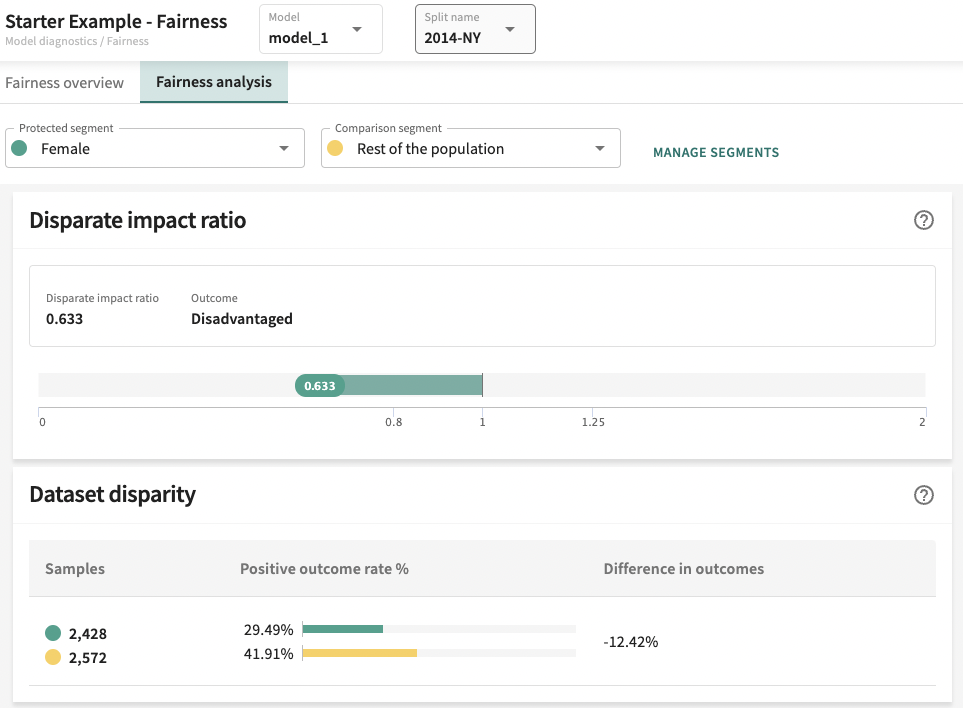

In [ ]:
# dataset disparity for 2014-NY
explainer = tru.get_explainer("2014-NY")
explainer.set_segment(segment_group_name = "Sex", segment_name = "Female")
mean_outcome_females_NY_2014 = explainer.get_ys().mean()
explainer.set_segment(segment_group_name = "Sex", segment_name = "Male")
mean_outcome_males_NY_2014 = explainer.get_ys().mean()
print("2014-NY dataset disparity: " + str(mean_outcome_females_NY_2014 - mean_outcome_males_NY_2014))

# dataset disparity for 2014-CA
explainer = tru.get_explainer("2014-CA")
explainer.set_segment(segment_group_name = "Sex", segment_name = "Female")
mean_outcome_females_CA_2014 = explainer.get_ys().mean()
explainer.set_segment(segment_group_name = "Sex", segment_name = "Male")
mean_outcome_males_CA_2014 = explainer.get_ys().mean()
print("2014-CA dataset disparity: " + str(mean_outcome_females_CA_2014 - mean_outcome_males_CA_2014))

2014-NY dataset disparity: -0.12423616644589686
2014-CA dataset disparity: -0.10761410632087881


This calculation of dataset disparity for NY and CA confirm our hypothesis.

Next, we should retrain our model on CA with the belief that more fair training data will lead to a more fair model.

In [ ]:
tru.set_environment('local')

# get data and feature map

from smart_open import open

data_s3_file_name = "https://truera-examples.s3.us-west-2.amazonaws.com/data/starter-fairness/starter-fairness-data.pickle"
with open(data_s3_file_name, 'rb') as f:
   data = pd.read_pickle(f)

feature_map_s3_file_name = "https://truera-examples.s3.us-west-2.amazonaws.com/data/starter-fairness/starter-fairness-feature-map.pickle"
with open(feature_map_s3_file_name, 'rb') as f:
   feature_map = pd.read_pickle(f)

# Train xgboost
models = {}
model_name_v2 = 'model_2'

models[model_name_v2] = xgb.XGBClassifier(eta = 0.2, max_depth = 4)

models[model_name_v2].fit(data[2014]['CA']['data_postprocessed'],
                        data[2014]['CA']['label'])

train_params = {"model_type":"xgb.XGBClassifier", "eta":0.2, "max_depth":4}

train_params['model_type'] = str(type(models[model_name_v2]))

# download and set project, data collection in local environment
tru.download_project(project_name)
tru.set_project(project_name)
tru.set_data_collection("Data Collection v1")

train_params['model_type'] = str(type(models[model_name_v2]))

# register the model
tru.add_python_model(model_name_v2,
                        models[model_name_v2],
                        train_split_name='2014-CA',
                        train_parameters = train_params
                        )

tru.upload_project()

tru.set_environment('remote')
tru.set_model(model_name_v2)
tru.tester.get_model_test_results(test_types = ["fairness"])

,Name,Split,Protected Segment,Comparison Segment,Metric,Score,Navigate
❌,Impact Ratio Test,2014-CA,Sex--Female: Sex = 'Female',REST OF POPULATION,DISPARATE_IMPACT_RATIO,0.701,Explore in UI
❌,Impact Ratio Test,2014-NY,Sex--Female: Sex = 'Female',REST OF POPULATION,DISPARATE_IMPACT_RATIO,0.664,Explore in UI
❌,Impact Ratio Test,2015-CA,Sex--Female: Sex = 'Female',REST OF POPULATION,DISPARATE_IMPACT_RATIO,0.71,Explore in UI
❌,Impact Ratio Test,2015-NY,Sex--Female: Sex = 'Female',REST OF POPULATION,DISPARATE_IMPACT_RATIO,0.7132,Explore in UI


* What? Shown in the model test results, the second version that was trained on CA data is substantially more fair than v1. However, v2 still fails the impact ratio test.

* Why? We notice that sex is included in the training data, and the second leading contributor to disparity. We should remove it so it's not learned by the model.

* What next? Let's see the fairness outcome after removing sex from the training data.

In [ ]:
# create the first project and data collection
tru.set_environment("local")

feature_map.pop('Sex')

tru.add_data_collection("Data Collection v2",
                        pre_to_post_feature_map = feature_map,
                        provide_transform_with_model = False)

# add data splits to the collection we just created
year_begin = 2014
year_end = 2016 # exclusive
states = ['CA', 'NY']
first_iteration = True

for year in range(year_begin, year_end):
    for state in states:
        tru.add_data_split(f'{year}-{state}', pre_data = data[year][state]['data_preprocessed'].drop('Sex', axis = 1), # drop sex from pre-data
                            post_data = data[year][state]['data_postprocessed'].drop(['Sex_Female','Sex_Male'], axis = 1), # drop sex from post-data
                            label_data = data[year][state]['label'],
                            extra_data_df = data[year][state]['extra_data'].reset_index(drop=True).join(data[year][state]['data_preprocessed']['Sex'].reset_index(drop=True)), # add sex to extra data
                            split_type = "all")
                            
        if first_iteration:
            tru.add_segment_group("Sex", {"Male": "Sex == 'Male'", "Female": "Sex == 'Female'"})
            tru.add_segment_group("Language at home", {"English": "LANX == 1", "Not English": "LANX == 2"})
            first_iteration = False

In [ ]:
# Train xgboost
models = {}
model_name_v3 = 'model_3'

models[model_name_v3] = xgb.XGBClassifier(eta = 0.2, max_depth = 4)

models[model_name_v3].fit(data[2014]['CA']['data_postprocessed'].drop(['Sex_Female','Sex_Male'], axis = 1),
                        data[2014]['CA']['label'])

train_params['model_type'] = str(type(models[model_name_v3]))

# register the model
tru.add_python_model(model_name_v3,
                        models[model_name_v3],
                        train_split_name='2014-CA',
                        train_parameters=train_params)

tru.upload_project()

tru.set_environment('remote')
tru.set_model(model_name_v3)
tru.tester.get_model_test_results(test_types = ["fairness"])

,Name,Split,Protected Segment,Comparison Segment,Metric,Score,Navigate
❌,Impact Ratio Test,2014-CA,Sex--Female: Sex = 'Female',REST OF POPULATION,DISPARATE_IMPACT_RATIO,0.7909,Explore in UI
❌,Impact Ratio Test,2014-NY,Sex--Female: Sex = 'Female',REST OF POPULATION,DISPARATE_IMPACT_RATIO,0.7508,Explore in UI
❌,Impact Ratio Test,2015-NY,Sex--Female: Sex = 'Female',REST OF POPULATION,DISPARATE_IMPACT_RATIO,0.7897,Explore in UI
✅,Impact Ratio Test,2015-CA,Sex--Female: Sex = 'Female',REST OF POPULATION,DISPARATE_IMPACT_RATIO,0.8082,Explore in UI


* What? Our newest model now passes 1/4 impact ratio tests.
* Shown on the Dataset Disparity section of the Fairness page in the web app, we notice that there is a lower positive outcome rate for females in the data. Let's check the performance of females with a positive label.

In [ ]:
explainer = tru.get_explainer(base_data_split='2014-CA')
tru.set_data_split("2014-CA")
tru.add_segment_group("Sex + Label", {"Other": "(Sex == 'Male') OR (_DATA_GROUND_TRUTH == 0)",
                                      "Female + Label 1": "(Sex == 'Female') AND (_DATA_GROUND_TRUTH == 1)"})
explainer.set_segment(segment_group_name = "Sex + Label", segment_name = "Female + Label 1")
print("Female + label 1 performance: " + str(explainer.compute_performance(metric_type="CLASSIFICATION_ACCURACY")))
explainer.set_segment(segment_group_name = "Sex + Label", segment_name = "Other")
print("Other performance: " + str(explainer.compute_performance(metric_type="CLASSIFICATION_ACCURACY")))

Female + label 1 performance: 0.7353801131248474
Other performance: 0.8549582958221436


Our hunch was correct. To correct for this, rebalance the training set by overampling female with label==1 in train set because female with label==1 has more error than rest_of_pop with label==1

In [ ]:
def rebalance_gender(df, data_type):
    if data_type == 0:
        df_female_true = df[(df['Sex'] == 'Female') & (df['PINCP'] == True)]
        df_else = df[~((df['Sex'] == 'Female') & (df['PINCP'] == True))]
    else:
        df_female_true = df[(df['Sex_Female'] == 1) & (df['PINCP'] == True)]
        df_else = df[~((df['Sex_Female'] == 1) & (df['PINCP'] == True))]

    if data_type == 0:
        num_samples = len(df[(df['Sex'] == 'Male') & (df['PINCP'] == True)])
    else:
        num_samples = len(df[(df['Sex_Male'] == 1) & (df['PINCP'] == True)])
    # Resample female target segment so that they are the same size as male 
    df_female_true_resampled = resample(
        df_female_true, 
        replace=True,
        n_samples=num_samples,
        random_state=1 # include random seed so we can perform same sampling on each data set
        )

    return pd.concat([df_female_true_resampled, df_else])

In [ ]:
data[2014]['CA']['data_preprocessed_resampled'] = rebalance_gender(data[2014]['CA']['data_preprocessed'].reset_index(drop=True).\
                                        join(data[2014]['CA']['label'].reset_index(drop=True)), 0).drop(['Sex','PINCP'], axis = 1)
data[2014]['CA']['data_postprocessed_resampled'] = rebalance_gender(data[2014]['CA']['data_postprocessed'].reset_index(drop=True).\
                                        join(data[2014]['CA']['label'].reset_index(drop=True)), 1).drop(['Sex_Male','Sex_Female', 'PINCP'], axis = 1)
data[2014]['CA']['label_resampled'] = rebalance_gender(pd.DataFrame(data[2014]['CA']['label'].reset_index(drop=True)).\
                                        join(data[2014]['CA']['data_preprocessed']['Sex'].reset_index(drop=True)), 0).drop(['Sex'], axis = 1)
data[2014]['CA']['extra_data_resampled'] = rebalance_gender(pd.DataFrame(data[2014]['CA']['extra_data'].reset_index(drop=True)).\
                                        join(data[2014]['CA']['data_preprocessed']['Sex'].reset_index(drop=True)).\
                                        join(data[2014]['CA']['label'].reset_index(drop=True)), 0).drop(['Sex','PINCP'], axis = 1)

In [ ]:
tru.set_environment("local")
tru.add_data_split("2014-CA-resampled",
    pre_data=data[2014]['CA']['data_preprocessed_resampled'],
    post_data=data[2014]['CA']['data_postprocessed_resampled'],
    label_data=data[2014]['CA']['label_resampled'],
    extra_data_df=data[2014]['CA']['extra_data_resampled']
)
tru.upload_project()

In [ ]:
# Specify training parameters

# Train xgboost
models = {}
model_name_v4 = 'model_4'

models[model_name_v4] = xgb.XGBClassifier(eta = 0.2, max_depth = 4)

models[model_name_v4].fit(data[2014]['CA']['data_postprocessed_resampled'],
                        data[2014]['CA']['label_resampled'])

train_params['model_type'] = str(type(models[model_name_v4]))

# register the model
tru.add_python_model(model_name_v4,
                        models[model_name_v4],
                        train_split_name='2014-CA-resampled',
                        train_parameters = train_params
                        )

tru.upload_project()

tru.set_environment('remote')
tru.set_model(model_name_v4)
tru.tester.get_model_test_results(test_types = ["fairness"])

,Name,Split,Protected Segment,Comparison Segment,Metric,Score,Navigate
,Impact Ratio Test,2014-CA-resampled,Sex--Female: Sex = 'Female',REST OF POPULATION,DISPARATE_IMPACT_RATIO,N/A,Explore in UI
✅,Impact Ratio Test,2014-CA,Sex--Female: Sex = 'Female',REST OF POPULATION,DISPARATE_IMPACT_RATIO,0.8433,Explore in UI
✅,Impact Ratio Test,2014-NY,Sex--Female: Sex = 'Female',REST OF POPULATION,DISPARATE_IMPACT_RATIO,0.8057,Explore in UI
✅,Impact Ratio Test,2015-CA,Sex--Female: Sex = 'Female',REST OF POPULATION,DISPARATE_IMPACT_RATIO,0.8381,Explore in UI
✅,Impact Ratio Test,2015-NY,Sex--Female: Sex = 'Female',REST OF POPULATION,DISPARATE_IMPACT_RATIO,0.8356,Explore in UI


### After reblancing, the model passes 4/4 impact ratio tests, giving us confidence in the fairness of the model.